<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


####**Impact of geographic scales**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.




**Read original workload query outputs**  
We consider the query of race for the purpose of demonstration. Cell uniqueness is presented in this query.

In [33]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist1 = 'data/franklin/microdata/franklin_hist.csv'
hist1 = pd.read_csv(filename_hist1)
hist1['BLK'] = hist1['GEOID10'].astype(str)
col_names = hist1.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist1 = hist1.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1.columns if x in col[6:8]]
        hist1[str(x)] = hist1[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist1.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist1['06'] = hist1[col_two_or_more_races].sum(axis=1)
hist1.drop([col for col in hist1.columns if len(col)==8], axis=1, inplace=True)
hist1

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390490001101000,0,0,0,0,0,0,0
390490001101001,1,0,0,0,0,0,0
390490001101002,45,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0
...,...,...,...,...,...,...,...
390499800001070,0,0,0,0,0,0,0
390499800001071,0,0,0,0,0,0,0
390499800001072,0,0,0,0,0,0,0


**Read dp workload query outputs**  

In [40]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import numpy as np

n4 = 63
filename_hist2 = 'data/franklin/microdata/rho_2.56/franklin_hist_dp_blk2.csv'
hist2 = pd.read_csv(filename_hist2)
hist2['BLK'] = hist2['BLK'].astype(str)
col_names = hist2.columns.to_numpy()
col_names = np.delete(col_names, [0, -1])
hist2 = hist2.groupby('BLK').sum()[col_names]

col_two_or_more_races = []
for x in range(n4):     # race
    if x >= 0 and x <= 5:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2.columns if x in col[6:8]]
        hist2[str(x)] = hist2[col_names].sum(axis=1)
    else:
        x = '{number:0{width}d}'.format(width=2, number=x)
        col_names = [col for col in hist2.columns if x in col[6:8]]
        col_two_or_more_races.extend(col_names)
hist2['06'] = hist2[col_two_or_more_races].sum(axis=1)
hist2.drop([col for col in hist2.columns if len(col)==8], axis=1, inplace=True)
hist2

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,00,01,02,03,04,05,06
BLK,,,,,,,
390490001101000,0.0,2.0,0.0,1.0,0.0,2.0,0.0
390490001101001,1.0,0.0,0.0,3.0,1.0,1.0,1.0
390490001101002,43.0,0.0,0.0,0.0,0.0,2.0,1.0
390490001101003,55.0,5.0,0.0,0.0,0.0,0.0,1.0
390490001101004,49.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
390499800001070,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390499800001071,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390499800001072,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#####**Impact of resolutions (aggregation levels)**
We test the probability of finding a true unique at block, block group, and tract levels. We make comparisons among (1) our results, (2) NHGIS data from the 2021-06-08 vintage of the PPMF, and (3) the OLS estimators. 

Group 1: Franklin County, my data

In [41]:
## block
hist1_blk, hist2_blk = hist1, hist2
tu = (hist1_blk == hist2_blk) & (hist1_blk == 1) & (hist2_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_blk == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_blk = n_tu / n_u   # frequency of finding the true uniques

## block group
col_names = hist1.columns.to_numpy()
hist1_bg = hist1.groupby(hist1.index.astype(str).str[:12]).sum()
hist1_bg.index.name = 'BG'
hist2_bg = hist2.groupby(hist2.index.astype(str).str[:12]).sum()
hist2_bg.index.name = 'BG'

tu = (hist1_bg == hist2_bg) & (hist1_bg == 1) & (hist2_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_bg == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_bg = n_tu / n_u   # frequency of finding the true uniques

## tract
col_names = hist1.columns.to_numpy()
hist1_tr = hist1.groupby(hist1.index.astype(str).str[:11]).sum()
hist1_tr.index.name = 'TRACT'
hist2_tr = hist2.groupby(hist2.index.astype(str).str[:11]).sum()
hist2_tr.index.name = 'TRACT'

tu = (hist1_tr == hist2_tr) & (hist1_tr == 1) & (hist2_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_tr == 1  # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_tr = n_tu / n_u   # frequency of finding the true uniques

print(p_tu_blk, p_tu_bg, p_tu_tr)

0.06568958245466049 0.13142857142857142 0.15384615384615385


Group 2: Franklin County, NHGIS data (2021-06-08)

In [47]:
# ppmf
import pandas as pd

## block
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_block_OH.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_blk = hist1_nhgis_blk.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_blk = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_blk = hist2_nhgis_blk.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_blk == hist2_nhgis_blk) & (hist1_nhgis_blk == 1) & (hist2_nhgis_blk == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_blk == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_blk = n_tu / n_u # frequency of finding the true uniques

## block group
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_blck_grp.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_bg = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_bg == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_bg = n_tu / n_u # frequency of finding the true uniques

## tract
filename_nhgis = 'data/nhgis/nhgis_ppdd_20210608_tract.csv'
data_nhgis = pd.read_csv(filename_nhgis, encoding = "ISO-8859-1")
data_nhgis["STATE"] = data_nhgis["gisjoin"].str.slice(1, 3)
data_nhgis['COUNTY'] = data_nhgis["gisjoin"].str.slice(4, 7)
data_nhgis = data_nhgis[(data_nhgis["STATE"] == '39') & (data_nhgis["COUNTY"] == '049')]
data_nhgis = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp', 
                         'H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = data_nhgis[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 
                                                  'H72007_sf': '5', 'H72008_sf': '6', 'H72009_sf': '7'})
hist2_nhgis_tr = data_nhgis[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 
                                                  'H72007_dp': '5', 'H72008_dp': '6', 'H72009_dp': '7'})

tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1) # find a true unique
n_tu = np.unique(tu.values, return_counts=True)[1][1]
u = hist2_nhgis_tr == 1    # uniques after noise injection
n_u = np.unique(u.values, return_counts=True)[1][1]
p_tu_nhgis_tr = n_tu / n_u # frequency of finding the true uniques

print(p_tu_nhgis_blk, p_tu_nhgis_bg, p_tu_nhgis_tr)

0.09278543777592396 0.2316715542521994 0.18181818181818182


Group 3: Franklin County, OLS

#### **Add noises (Zero-concentrated differential privacy)**
There are two core components to the 2020 DAS: noise injection and post-processing. We only focus on the noise injection here. Consistent with the 2020 DAS, discrete Gaussian noise is applied.

Bun, M., & Steinke, T. (2016, November). Concentrated differential privacy: Simplifications, extensions, and lower bounds. In Theory of Cryptography Conference (pp. 635-658). Springer, Berlin, Heidelberg.

Parameters for generating Gaussian noise.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import math
from fractions import Fraction

import lib.discretegauss as discretegauss
import lib.cdp2adp as cdp2adp

eps = 17.14
delta = 1e-10
# convert to concentrated DP
rho = cdp2adp.cdp_rho(eps, delta)
print(str(rho) + "-CDP implies (" + str(eps) + "," + str(delta) + ")-DP")
rho_per_q = Fraction(rho) * 9/4097 * 165/4099
rho_per_q
# compute noise variance parameter per query
sigma2 = 2 ** 2 / (2 * rho_per_q)
# actual variance, at most sigma2
var = discretegauss.variance(sigma2)
print("standard deviation for each count = " + str(math.sqrt(var)))

/content/gdrive/My Drive/Colab Notebooks/census_privacy
2.5553177660014468-CDP implies (17.14,1e-10)-DP
standard deviation for each count = 94.0808548569315


In [ ]:
hist2 = hist1 + np.round(np.random.normal(0, math.sqrt(sigma2), size=(hist1.shape)), 0)
hist2

race,1,2,3,4,5,6,7
GEOID10,,,,,,,
390490001101001,-7.0,-3.0,-5.0,7.0,3.0,1.0,4.0
390490001101002,54.0,16.0,0.0,3.0,3.0,-8.0,5.0
390490001101003,55.0,6.0,13.0,-1.0,-4.0,-6.0,-1.0
390490001101004,50.0,0.0,0.0,0.0,-3.0,5.0,5.0
390490001101005,50.0,1.0,-4.0,6.0,4.0,-22.0,8.0
...,...,...,...,...,...,...,...
390490107001015,104.0,22.0,2.0,5.0,-2.0,0.0,11.0
390490107001016,17.0,6.0,-4.0,1.0,12.0,14.0,-4.0
390490107001017,40.0,-1.0,0.0,11.0,18.0,-8.0,3.0


Add noise to histogram.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import lib.discretegauss as discretegauss

noise = np.empty(hist1.shape, dtype=int)
for i in range(hist1.shape[0]):
    for j in range(hist1.shape[1]):
        noise[i, j] = discretegauss.sample_dgauss(sigma2)

hist2 = hist1 + noise
hist2

/content/gdrive/My Drive/Colab Notebooks/census_privacy


race,1,2,3,4,5,6,7
GEOID10,,,,,,,
390490001101001,12,-132,-40,71,73,-41,149
390490001101002,124,219,-113,41,10,-20,76
390490001101003,99,-44,-52,123,114,99,26
390490001101004,-150,-31,138,-17,98,-26,50
390490001101005,156,-155,-14,-75,-104,-93,-9
...,...,...,...,...,...,...,...
390490107001015,-6,138,106,51,187,12,128
390490107001016,-55,97,36,72,-59,-58,32
390490107001017,24,-38,-117,-174,-1,-79,145


####**Cell uniqueness**
Young, C., Martin, D., & Skinner, C. (2009). Geographically intelligent disclosure control for flexible aggregation of census data. International Journal of Geographical Information Science, 23(4), 457-482.

Privacy measure: probability of finding a true unique

In [19]:
# find a true unique
tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
n_tu

623

In [20]:
# uniques after noise injection
u = hist2 == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
n_u

9484

In [21]:
# frequency of finding the true uniques
p_tu = n_tu / n_u
p_tu

0.06568958245466049

Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

$p(TU)=\frac{p(W=0)p(A_1)}{\sum_ip(W=1-i)p(A_i)}$


$p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [ ]:
import scipy.stats

column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.06967364027048083

We also use a Monte Carlo method to calculate the expected frequency (probability) of finding the true uniques. The result is consistent with the theoretical value.

In [ ]:
import statistics
import numpy as np

N = 1000    # bootstrap times
p_tus = []

for i in range(N):
    hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
    # find a true unique
    tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2 == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu = n_tu / n_u
    p_tus.append(p_tu)

statistics.mean(p_tus)

0.0790808269701855

Compare with the Privacy-Protected 2010 Census Demonstration Data derived from the 2021-06-08 vintage of the PPMF. The result shows that after post-processing, the $p(TU)$ is potentially larger than that calculated immediately after noise injection.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_nhgis = n_tu / n_u
p_tu_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.11636167922497309

We also compare the results with that derived in the Guernsey county, which only has a population of 40,087.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import seaborn as sns

filename_people_g = 'guernsey/microdata/guernsey_people_all.csv'
data_people_g = pd.read_csv(filename_people_g)
data_people_g['GEOID10'] = data_people_g['GEOID10'].astype(str)
data_people_g['BGID10'] = data_people_g['GEOID10'].str[:12]
data_people_g['TRACTID10'] = data_people_g['GEOID10'].str[:11]
data_people_g.head()

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,race,sex,age,age_v,BGID10,TRACTID10
0,390599771001005,1,1,1,1,390599771001,39059977100
1,390599771001005,1,1,1,1,390599771001,39059977100
2,390599771001005,1,1,1,2,390599771001,39059977100
3,390599771001005,1,1,1,0,390599771001,39059977100
4,390599771001005,1,1,1,2,390599771001,39059977100


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

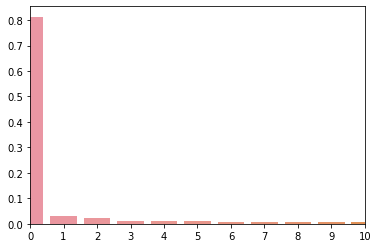

In [ ]:
import seaborn as sns

hist1_g = pd.crosstab(data_people_g.GEOID10, data_people_g.race)
probabilities = hist1_g.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [ ]:
import scipy.stats

column_values = hist1_g[hist1_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_g = p3 * p4 / sum(probs)
p_tu_g

0.030857459138181408

In [ ]:
# compare with NHGIS
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_block_g = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block_g = pd.read_csv(filename_nhgis_block_g)

hist1_nhgis_g = nhgis_block_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_g = hist1_nhgis_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_g = nhgis_block_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_g = hist2_nhgis_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_g == hist2_nhgis_g) & (hist1_nhgis_g == 1) & (hist2_nhgis_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_nhgis_g = n_tu / n_u
p_tu_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.05958132045088567

####**More on cell uniqueness**
Some simulations to demonstrate how spatial scales affect the probability of finding a true unique. Two aspects of spatial scales are examined here: resolution and extent.

#####**Impact of resolutions (aggregation levels)**
We test the probability of finding a true unique at both block group and tract levels. As shown below, as we increase the aggregation level, the probability raises. This is potentially due to the fact that the histogram is less clustered around the small numbers (e.g., 2, 3, 0 that are easily transformed to 1 when adding noises).

######**Block group**

In [ ]:
hist1_bg = pd.crosstab(data_people.BGID10, data_people.race)
hist1_bg

race,1,2,3,4,5,6,7
BGID10,,,,,,,
390490001101,1040,14,0,8,0,3,15
390490001102,814,15,0,18,0,3,7
390490001103,619,6,2,6,0,6,9
390490001104,744,5,0,4,0,1,5
390490001201,758,6,0,11,0,2,12
...,...,...,...,...,...,...,...
390490106021,1369,48,4,41,0,17,31
390490106022,2293,59,1,159,0,17,45
390490106023,1824,50,4,220,0,20,37


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

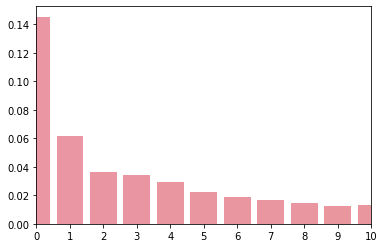

In [ ]:
import seaborn as sns

probabilities = hist1_bg.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [ ]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
rho = 2.56 * 3/4099

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * rho))
# privacy loss budget in differential privacy
eps = rho + 2 * math.sqrt(rho * math.log(1 / delta))

rho, eps, sigma

(0.001873627714076604, 0.417286061050071, 16.33591072351544)

In [ ]:
import scipy.stats

column_values = hist1_bg[hist1_bg.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_bg = p3 * p4 / sum(probs)
p_tu_bg

0.1247062657604142

In [ ]:
# Compare with NHGIS data
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_bg = 'franklin/nhgis/franklin_nhgis_bg.csv'
nhgis_bg = pd.read_csv(filename_nhgis_bg)

hist1_nhgis_bg = nhgis_bg[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg = hist1_nhgis_bg.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_bg = nhgis_bg[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg = hist2_nhgis_bg.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_bg == hist2_nhgis_bg) & (hist1_nhgis_bg == 1) & (hist2_nhgis_bg == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_bg == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_bg_nhgis = n_tu / n_u
p_tu_bg_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.2316715542521994

Compare with Guernsey county.

In [ ]:
import scipy.stats

hist1_bg_g = pd.crosstab(data_people_g.BGID10, data_people_g.race)
column_values = hist1_bg_g[hist1_bg_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_bg_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_bg_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_bg_g = p3 * p4 / sum(probs)
p_tu_bg_g

0.16603359268777793

In [ ]:
# Compare with NHGIS data (Guernsey)
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_bg_g = 'guernsey/nhgis/guernsey_nhgis_bg.csv'
nhgis_bg_g = pd.read_csv(filename_nhgis_bg_g)

hist1_nhgis_bg_g = nhgis_bg_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_bg_g = hist1_nhgis_bg_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_bg_g = nhgis_bg_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_bg_g = hist2_nhgis_bg_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_bg_g == hist2_nhgis_bg_g) & (hist1_nhgis_bg_g == 1) & (hist2_nhgis_bg_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_bg_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_bg_nhgis_g = n_tu / n_u
p_tu_bg_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.3448275862068966

######**Tract**

In [ ]:
hist1_tr = pd.crosstab(data_people.TRACTID10, data_people.race)
hist1_tr

race,1,2,3,4,5,6,7
TRACTID10,,,,,,,
39049000110,3217,40,2,36,0,13,36
39049000120,3016,44,3,42,1,7,49
39049000210,2773,52,5,32,0,10,63
39049000220,3536,32,4,55,0,24,76
39049000310,2135,739,3,70,2,61,137
...,...,...,...,...,...,...,...
39049010500,6499,108,4,1179,1,43,119
39049010601,3933,128,3,453,0,32,95
39049010602,5486,157,9,420,0,54,113


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0.0, 10.0)]

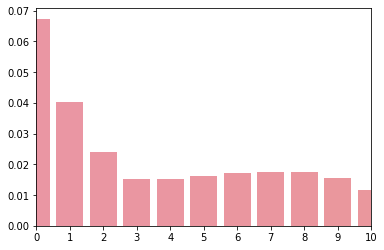

In [ ]:
import seaborn as sns

probabilities = hist1_tr.stack().value_counts(normalize=True)    
sns.barplot(probabilities.index, probabilities.values).set(xlim=(0, 10))

In [ ]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
rho = 2.56 * 4/2051

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * rho))
# privacy loss budget in differential privacy
eps = rho + 2 * math.sqrt(rho * math.log(1 / delta))

rho, eps, sigma

(0.004992686494392979, 0.6831102425562302, 10.007321538503698)

In [ ]:
import scipy.stats

column_values = hist1_tr[hist1_tr.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_tr = p3 * p4 / sum(probs)
p_tu_tr

0.14954544232212066

In [ ]:
# Compare with NHGIS data
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_tr = 'franklin/nhgis/franklin_nhgis_tract.csv'
nhgis_tr = pd.read_csv(filename_nhgis_tr)

hist1_nhgis_tr = nhgis_tr[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr = hist1_nhgis_tr.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_tr = nhgis_tr[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr = hist2_nhgis_tr.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_tr == hist2_nhgis_tr) & (hist1_nhgis_tr == 1) & (hist2_nhgis_tr == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_tr == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_tr_nhgis = n_tu / n_u
p_tu_tr_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.18181818181818182

Compare with Guernsey county.

In [ ]:
import scipy.stats

hist1_tr_g = pd.crosstab(data_people_g.TRACTID10, data_people_g.race)
column_values = hist1_tr_g[hist1_tr_g.columns].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1_tr_g == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1_tr_g == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu_tr_g = p3 * p4 / sum(probs)
p_tu_tr_g

0.12673117475298584

In [ ]:
# Compare with NHGIS data (Guernsey)
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_nhgis_tr_g = 'guernsey/nhgis/guernsey_nhgis_tract.csv'
nhgis_tr_g = pd.read_csv(filename_nhgis_tr_g)

hist1_nhgis_tr_g = nhgis_tr_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_tr_g = hist1_nhgis_tr_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_tr_g = nhgis_tr_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_tr_g = hist2_nhgis_tr_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# find a true unique
tu = (hist1_nhgis_tr_g == hist2_nhgis_tr_g) & (hist1_nhgis_tr_g == 1) & (hist2_nhgis_tr_g == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
# uniques after noise injection
u = hist2_nhgis_tr_g == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
# frequency of finding the true uniques
p_tu_tr_nhgis_g = n_tu / n_u
p_tu_tr_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


0.5

We can plot the $p(TU)$ under different aggregation levels using a bar chart.

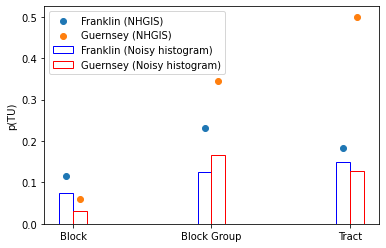

In [ ]:
import matplotlib.pyplot as plt

labels = ['Block', 'Block Group', 'Tract']
p_tu_1 = [p_tu, p_tu_bg, p_tu_tr]
p_tu_2 = [p_tu_nhgis, p_tu_bg_nhgis, p_tu_tr_nhgis]
p_tu_3 = [p_tu_g, p_tu_bg_g, p_tu_tr_g]
p_tu_4 = [p_tu_nhgis_g, p_tu_bg_nhgis_g, p_tu_tr_nhgis_g]

x = np.arange(len(labels))  # the label locations
width = 0.1 # the width of the bars

fig, ax = plt.subplots()
colors = [(0, 0, 1, 1), (1, 0, 0, 1)]

rects1 = ax.bar(x - 0.5 * width, p_tu_1, width, label='Franklin (Noisy histogram)', color=(0,0,0,0), edgecolor=colors[0])
rects3 = ax.bar(x + 0.5 * width, p_tu_3, width, label='Guernsey (Noisy histogram)', color=(0,0,0,0), edgecolor=colors[1])
rects2 = ax.scatter(x - 0.5 * width, p_tu_2, label='Franklin (NHGIS)')
rects4 = ax.scatter(x + 0.5 * width, p_tu_4, label='Guernsey (NHGIS)')

ax.set_ylabel('p(TU)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

#####**Impact of extents**

Read block and tract data.

In [ ]:
!pip install geopandas
!pip install pysal

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block['GEOID10'] = data_block['GEOID10'].astype(str)
data_block['BGID10'] = data_block['GEOID10'].str[:12]
data_block['TRACTID10'] = data_block['GEOID10'].str[:11]
data_block.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID_1', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10',
       'GEOID10', 'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'PUMA',
       'Shape_Length', 'Shape_Area', 'BGID10', 'TRACTID10', 'geometry'],
      dtype='object')

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract = 'franklin/buildings/franklin_tract10.json'
data_tract = gpd.read_file(filename_tract)
data_tract['GEOID10'] = data_tract['GEOID10'].astype(str)
data_tract.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

######**Continuous neighbors**

Find blocks in the most populated tract (largest population density).

In [ ]:
total = hist1_tr.sum(axis=1).to_frame()
total["GEOID10"] = total.index.map(str)
total = total.rename(columns={total.columns[0]: "POP"})
total.index.name = None
data_tract_new = data_tract.merge(total[['GEOID10', 'POP']], how='left', on=['GEOID10'])
total.head()

,POP,GEOID10
39049000110,3344,39049000110
39049000120,3162,39049000120
39049000210,2935,39049000210
39049000220,3727,39049000220
39049000310,3147,39049000310


In [ ]:
data_tract_new["POP_DEN"] = data_tract_new["POP"] / data_tract_new["ALAND10"]
max_index = data_tract_new["POP_DEN"].idxmax()
max_id = data_tract_new.loc[max_index].at['GEOID10']
max_index, max_id

(232, '39049001810')

We can keep searching the neighbors based on Rook continuity until all blocks in the county are covered. 

In [ ]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
rho = 2.56 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * rho))
# privacy loss budget in differential privacy
eps = rho + 2 * math.sqrt(rho * math.log(1 / delta))

rho, eps, sigma

(0.005623627044178667, 0.7253146663237842, 9.429241235527797)

In [ ]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_all = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1

    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    data_people_sub = data_people[data_people["TRACTID10"].isin(tract_ids)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)
    
    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all.append(p_tu)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_all

[0.1425634364619828,
 0.09094839356570802,
 0.10382830930448199,
 0.1031387703888544,
 0.09267993905539498,
 0.08745329946181782,
 0.08402071308928735,
 0.08238798414803729,
 0.08035829609353787,
 0.07990075583278043,
 0.07946967429507722,
 0.07905880704376685]

We can use the same procedure to calculate $p(TU)$ based on the NHGIS data.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)
nhgis_block['TRACTID10'] = nhgis_block['GEOID10'].str[:11]

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract)

tract_index = [max_index]
p_tu_all_nhgis = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract):
        flag = 1
        
    # create histogram
    tract_ids = data_tract["GEOID10"].iloc[tract_index]
    nhgis_sub = nhgis_block[nhgis_block["TRACTID10"].isin(tract_ids)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis.append(p_tu_nhgis)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
p_tu_all_nhgis

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.2857142857142857,
 0.18032786885245902,
 0.16194331983805668,
 0.15014436958614052,
 0.13876040703052728,
 0.13541971336648143,
 0.12558998563513235,
 0.12069244458825433,
 0.11913404200155561,
 0.11832412523020258,
 0.11727989487516426,
 0.11636167922497309]

Compare with Guernsey county.

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block_g = 'guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)
data_block_g['BGID10'] = data_block_g['GEOID10'].str[:12]
data_block_g['TRACTID10'] = data_block_g['GEOID10'].str[:11]
data_block_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'FUNCSTAT10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry', 'BGID10',
       'TRACTID10'],
      dtype='object')

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_tract_g = 'guernsey/buildings/guernsey_tract10.json'
data_tract_g = gpd.read_file(filename_tract_g)
data_tract_g['GEOID10'] = data_tract_g['GEOID10'].astype(str)
data_tract_g.columns

/content/gdrive/My Drive/Colab Notebooks/census_privacy


Index(['FID', 'STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [ ]:
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

total_g = hist1_tr_g.sum(axis=1).to_frame()
total_g["GEOID10"] = total_g.index.map(str)
total_g = total_g.rename(columns={total_g.columns[0]: "POP"})
total_g.index.name = None
data_tract_new_g = data_tract_g.merge(total_g[['GEOID10', 'POP']], how='left', on=['GEOID10'])

data_tract_new_g["POP_DEN"] = data_tract_new_g["POP"] / data_tract_new_g["ALAND10"]
max_index = data_tract_new_g["POP_DEN"].idxmax()
max_id = data_tract_new_g.loc[max_index].at['GEOID10']

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)
tract_index = [max_index]
p_tu_all_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    data_people_sub = data_people_g[data_people_g["TRACTID10"].isin(tract_ids)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all_g.append(p_tu)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
    # print(len(tract_index))
p_tu_all_g

[0.06441614538205882,
 0.0483149738383513,
 0.03387245507887868,
 0.030857459138181408]

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
import scipy.stats

filename_nhgis_block_g = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block_g = pd.read_csv(filename_nhgis_block_g)
nhgis_block_g['GEOID10'] = nhgis_block_g['GEOID10'].astype(str)
nhgis_block_g['TRACTID10'] = nhgis_block_g['GEOID10'].str[:11]

hist1_nhgis_g = nhgis_block_g[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis_g = hist1_nhgis_g.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis_g = nhgis_block_g[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis_g = hist2_nhgis_g.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

# k-nearest neighbors for all tracts
k10 = weights.Rook.from_dataframe(data_tract_g)

tract_index = [max_index]
p_tu_all_nhgis_g = []
flag = 0
while flag < 1:
    if len(tract_index) == len(data_tract_g):
        flag = 1
        
    # create histogram
    tract_ids = data_tract_g["GEOID10"].iloc[tract_index]
    nhgis_sub = nhgis_block_g[nhgis_block_g["TRACTID10"].isin(tract_ids)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis_g.append(p_tu_nhgis)

    # add neighbors 
    nb_index = [k10.neighbors.get(tract) for tract in tract_index]
    nb_index = [x for sublist in nb_index for x in sublist]
    tract_index = list(set(np.append(tract_index, nb_index)))
p_tu_all_nhgis_g

/content/gdrive/My Drive/Colab Notebooks/census_privacy


[0.08823529411764706,
 0.06428571428571428,
 0.061630218687872766,
 0.05958132045088567]

We visualize the trend of $p(TU)$ during the expansion. As shown in the figure, $p(TU)$ increases in the first iteration, and then continues to decrease during the subsequent interations.

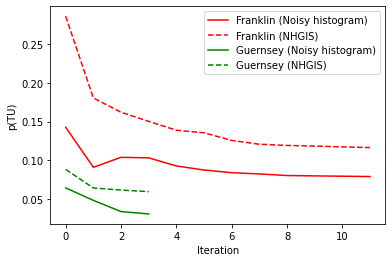

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_all), color = 'r', label='Franklin (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
plt.plot(np.array(p_tu_all_g), color = 'g', label='Guernsey (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

######**Random**

Randomly sample 10% of the blocks (without replacement) and add  to the histogram.

In [ ]:
import scipy.stats

filename_nhgis_block = 'franklin/nhgis/franklin_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

data_block_new = data_block
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu_all = []
p_tu_all_nhgis = []

while len(block_ids_all) < len(data_block):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    # create histogram
    data_people_sub = data_people[data_people["GEOID10"].isin(block_ids_all)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all.append(p_tu)

    ## NHGIS
    # create histogram
    nhgis_sub = nhgis_block[nhgis_block["GEOID10"].isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis = n_tu / n_u
    p_tu_all_nhgis.append(p_tu_nhgis)
    # print(len(block_ids_all))

p_tu_all, p_tu_all_nhgis

([0.08245813697285383,
  0.0813281976605486,
  0.08075435859372317,
  0.07997407871412415,
  0.07933184674349662,
  0.07921258953058226,
  0.07969534911465345,
  0.07939374567226849,
  0.07892789479412825,
  0.0790807663149489,
  0.07905880704376685],
 [0.11392405063291139,
  0.1086021505376344,
  0.11467236467236468,
  0.11644562334217506,
  0.11334320152252061,
  0.11237756010685664,
  0.11349598517603458,
  0.11296620438939006,
  0.11403299067654793,
  0.11638673557278209,
  0.11636167922497309])

Compare with Guernsey county.

In [ ]:
import scipy.stats
import geopandas as gpd

filename_block_g = 'guernsey/buildings/guernsey_block10.json'
data_block_g = gpd.read_file(filename_block_g)
data_block_g['GEOID10'] = data_block_g['GEOID10'].astype(str)

filename_nhgis_block = 'guernsey/nhgis/guernsey_nhgis_block.csv'
nhgis_block = pd.read_csv(filename_nhgis_block)
nhgis_block['GEOID10'] = nhgis_block['GEOID10'].astype(str)

hist1_nhgis = nhgis_block[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                          'H72009_sf': '7'})
hist2_nhgis = nhgis_block[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                          'H72009_dp': '7'})

data_block_new = data_block_g
N = int(0.1 * len(data_block_new))
block_ids_all = []
p_tu_all_g = []
p_tu_all_nhgis_g = []

while len(block_ids_all) < len(data_block_g):
    # sampling
    if len(data_block_new) >= N:
        block_ids = data_block_new["GEOID10"].sample(n=N)
    else: 
        block_ids = data_block_new["GEOID10"]
    block_ids_all = list(set(np.append(block_ids_all, block_ids)))
    data_block_new = data_block_new.loc[~data_block_new["GEOID10"].isin(block_ids)]    

    # create histogram
    data_people_sub = data_people_g[data_people_g["GEOID10"].isin(block_ids_all)]
    hist1_sub = pd.crosstab(data_people_sub.GEOID10, data_people_sub.race)

    # calculate p(TU)
    column_values = hist1_sub[hist1_sub.columns].values.ravel()
    A = pd.unique(column_values)
    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1_sub == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                               np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)
    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1_sub == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_all_g.append(p_tu)

    ## NHGIS
    # create histogram
    nhgis_sub = nhgis_block[nhgis_block["GEOID10"].isin(block_ids_all)]
    hist1_nhgis = nhgis_sub[['H72003_sf', 'H72004_sf', 'H72005_sf', 'H72006_sf', 'H72007_sf', 'H72008_sf', 'H72009_sf']]
    hist1_nhgis = hist1_nhgis.rename(columns={'H72003_sf': '1', 'H72004_sf': '2', 'H72005_sf': '3', 'H72006_sf': '4', 'H72007_sf': '5', 'H72008_sf': '6', 
                                            'H72009_sf': '7'})
    hist2_nhgis = nhgis_sub[['H72003_dp', 'H72004_dp', 'H72005_dp', 'H72006_dp', 'H72007_dp', 'H72008_dp', 'H72009_dp']]
    hist2_nhgis = hist2_nhgis.rename(columns={'H72003_dp': '1', 'H72004_dp': '2', 'H72005_dp': '3', 'H72006_dp': '4', 'H72007_dp': '5', 'H72008_dp': '6', 
                                            'H72009_dp': '7'})
    
    # calculate p(TU)
    # find a true unique
    tu = (hist1_nhgis == hist2_nhgis) & (hist1_nhgis == 1) & (hist2_nhgis == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2_nhgis == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu_nhgis_g = n_tu / n_u
    p_tu_all_nhgis_g.append(p_tu_nhgis_g)
    # print(len(block_ids_all))

p_tu_all_g, p_tu_all_nhgis_g

([0.036384098771528046,
  0.037373091481054464,
  0.03140369479531988,
  0.03271418399286753,
  0.034025121311531015,
  0.03281642294472919,
  0.03230153624392682,
  0.03160038730777287,
  0.03122452212617743,
  0.030758154638974234,
  0.030857459138181408],
 [0.046875,
  0.04504504504504504,
  0.0446927374301676,
  0.05,
  0.05177993527508091,
  0.0546448087431694,
  0.05568445475638051,
  0.055776892430278883,
  0.05653710247349823,
  0.05958132045088567,
  0.05958132045088567])

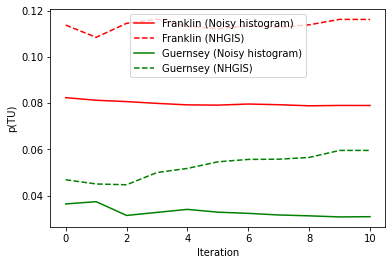

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_all), color = 'r', label='Franklin (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis), color = 'r', label='Franklin (NHGIS)', linestyle='dashed')
plt.plot(np.array(p_tu_all_g), color = 'g', label='Guernsey (Noisy histogram)')
plt.plot(np.array(p_tu_all_nhgis_g), color = 'g', label='Guernsey (NHGIS)', linestyle='dashed')
plt.xlabel("Iteration")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

#####**Impact of privacy loss budget (rho)**

For block level data, change epsilon from 1 to 20 while using the same allocation budget.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people.GEOID10, data_people.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

p_tu_rho = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_rho.append(p_tu)

p_tu_rho

Compare with Guernsey county.

In [ ]:
import scipy.stats
import math
import numpy as np

delta = 10 ** (-10)
hist1 = pd.crosstab(data_people_g.GEOID10, data_people_g.race)
column_values = hist1[hist1.columns].values.ravel()
A = pd.unique(column_values)

p_tu_rho_g = []
for k in np.arange(0.5, 21, 0.5):
    rho = k * 9/4097
    sigma = math.sqrt(1 / (2 * rho))

    probs = []
    for i in A:
        p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
        u0 = hist1 == i
        p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                            np.unique(u0.values, return_counts=True)[1][0])
        probs.append(p1 * p2)

    p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
    u0 = hist1 == 1
    p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                        np.unique(u0.values, return_counts=True)[1][0])
    p_tu = p3 * p4 / sum(probs)
    p_tu_rho_g.append(p_tu)

p_tu_rho_g

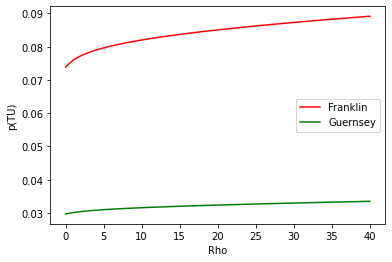

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.array(p_tu_rho), color = 'r', label='Franklin')
plt.plot(np.array(p_tu_rho_g), color = 'g', label='Guernsey')
plt.xlabel("Rho")
plt.ylabel("p(TU)")
plt.legend()
plt.show()

**Something to do with population density**

The trend above can potentially be explained by the population distribution in the county. As the iteration increases, more sparse blocks are added, and the histogram is more concentrated around zero. This can lead to the sharpe decrease in $p(TU)$.

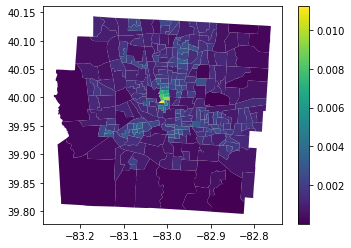

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
data_tract_new.plot(column='POP_DEN', ax=ax, legend=True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


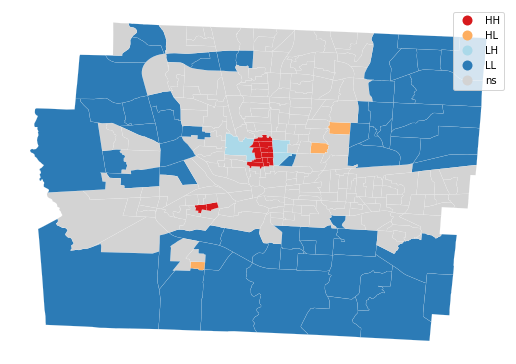

In [ ]:
from splot.esda import lisa_cluster
from pysal.lib import weights
from pysal.explore import esda

data_tract_new['POP_DEN'] = data_tract_new['POP_DEN'].fillna(0)
# Generate W from the GeoDataFrame
w = weights.Queen.from_dataframe(data_tract_new)
# Row-standardization
w.transform = 'R'

moran_loc = esda.moran.Moran_Local(data_tract_new['POP_DEN'].values, w)
lisa_cluster(moran_loc, data_tract_new, p=0.05, figsize = (9,9))
plt.show()